# BERT Sentiment Classification

Bidirectional Encoder Representations from Transformers (BERT) for Natural Language Understanding

* Transfer learning
* Fine tuning


In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
!pip install --quiet bert-for-tf2
!pip install --quiet sentencepiece

     |████████████████████████████████| 40kB 3.1MB/s 
     |████████████████████████████████| 1.0MB 5.1MB/s 


In [0]:
import tensorflow_hub as hub
import bert
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, Input, Dropout, Lambda
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import random

# Training Data

Download labeled data from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)

In [0]:
!unzip -q "sentiment labelled sentences.zip"

In [5]:
files = ['sentiment labelled sentences/yelp_labelled.txt', 'sentiment labelled sentences/amazon_cells_labelled.txt', 'sentiment labelled sentences/imdb_labelled.txt']

df_list = []
for file in files:
    df = pd.read_csv(file, names=['comment', 'sentiment'], sep='\t')
    df_list.append(df)

data = pd.concat(df_list)
data['length'] = data.comment.str.split(' ').str.len()

max_seq_length = 128

# Keep only short comments
shortComments = data[data.length < max_seq_length-5]
print('Number of rows: %d' % len(shortComments))

shortComments.head()

Number of rows: 2743


,comment,sentiment,length
0,Wow... Loved this place.,1,4
1,Crust is not good.,0,4
2,Not tasty and the texture was just nasty.,0,8
3,Stopped by during the late May bank holiday of...,1,15
4,The selection on the menu was great and so wer...,1,12


# Data Preparation

In [0]:
comments = shortComments.comment.astype(str).tolist()
sentiments = shortComments.sentiment.tolist()
labels = np.asarray(sentiments)

x_train, x_test, y_train, y_test = train_test_split(comments, labels, test_size=0.2, random_state=42)

In [0]:
bert_path = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(bert_path, trainable=False, name='BERT')
vocab_file1 = bert_layer.resolved_object.vocab_file.asset_path.numpy()
tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file1, do_lower_case=True)

In [0]:
def encodeText(textList):
  token_list = []
  att_list = []
  segment_list = []
  for text in textList:
    tokens = tokenizer.tokenize(text)
    padding = ['[PAD]'] * (max_seq_length - len(tokens) - 2)
    token_ids = tokenizer.convert_tokens_to_ids(['[CLS]'] + tokens + ['[SEP]'] + padding)
    token_list.append(token_ids)

    att_mask = [int(id > 0) for id in token_ids]
    att_list.append(att_mask)

    segment_ids = [0]*max_seq_length
    segment_list.append(segment_ids)
  return [tf.cast(token_list,tf.int32), tf.cast(att_list,tf.int32), tf.cast(segment_list,tf.int32)]

# Define Model

In [44]:
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
input_segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_segment_ids])

l1 = Lambda(lambda seq: seq[:, 0, :])(sequence_output)
output = Dense(2, activation='softmax')(l1)
model = Model([input_word_ids, input_mask, input_segment_ids], output)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
BERT (KerasLayer)               [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

# Transfer Learning

BERT layer weights/biases are frozen, only train the final dense layer.

In [45]:
history = model.fit(encodeText(x_train), y_train, epochs=5, verbose=1, batch_size = 3, validation_data=(encodeText(x_test), y_test))

Train on 2194 samples, validate on 549 samples
Epoch 1/5
2194/2194 [==============================] - 29s 13ms/sample - loss: 0.3695 - accuracy: 0.8478 - val_loss: 0.2838 - val_accuracy: 0.9016
Epoch 2/5
2194/2194 [==============================] - 20s 9ms/sample - loss: 0.2395 - accuracy: 0.9125 - val_loss: 0.2576 - val_accuracy: 0.8998
Epoch 3/5
2194/2194 [==============================] - 20s 9ms/sample - loss: 0.2123 - accuracy: 0.9225 - val_loss: 0.2439 - val_accuracy: 0.8998
Epoch 4/5
2194/2194 [==============================] - 19s 9ms/sample - loss: 0.1968 - accuracy: 0.9289 - val_loss: 0.2820 - val_accuracy: 0.8944
Epoch 5/5
2194/2194 [==============================] - 20s 9ms/sample - loss: 0.1926 - accuracy: 0.9262 - val_loss: 0.2849 - val_accuracy: 0.8998


# Fine Tuning

Unfreeze BERT layer, choose lower learning rate and retrain all layers.

In [46]:
bert_layer.trainable = True
output.trainable = False
model2 = Model([input_word_ids, input_mask, input_segment_ids], output)
model2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-5), metrics=['accuracy'])
model2.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
BERT (KerasLayer)               [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [47]:
history2 = model2.fit(encodeText(x_train), y_train, epochs=5, verbose=1, batch_size = 3, validation_data=(encodeText(x_test), y_test))

Train on 2194 samples, validate on 549 samples
Epoch 1/5
2194/2194 [==============================] - 63s 29ms/sample - loss: 0.1956 - accuracy: 0.9280 - val_loss: 0.1682 - val_accuracy: 0.9308
Epoch 2/5
2194/2194 [==============================] - 52s 24ms/sample - loss: 0.0271 - accuracy: 0.9923 - val_loss: 0.1870 - val_accuracy: 0.9435
Epoch 3/5
2194/2194 [==============================] - 52s 24ms/sample - loss: 0.0062 - accuracy: 0.9995 - val_loss: 0.1657 - val_accuracy: 0.9599
Epoch 4/5
2194/2194 [==============================] - 52s 24ms/sample - loss: 4.5760e-04 - accuracy: 1.0000 - val_loss: 0.2095 - val_accuracy: 0.9599
Epoch 5/5
2194/2194 [==============================] - 52s 24ms/sample - loss: 7.5577e-05 - accuracy: 1.0000 - val_loss: 0.2276 - val_accuracy: 0.9617


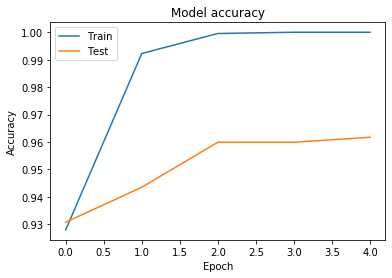

In [48]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Predictions

In [0]:
predictions = model2.predict(encodeText(x_test))
most_likely = predictions.argmax(1)

In [31]:
index = random.randrange(len(predictions))
print(x_test[index])
print('Prediction: %d, label: %d' % (most_likely[index], y_test[index]))

The acting is terrible, and the writing is worse.  
Prediction: 0, label: 0


# Error Analysis

A world better than 95% of the garbage in the theatres today.  
Prediction: 0, label: 1


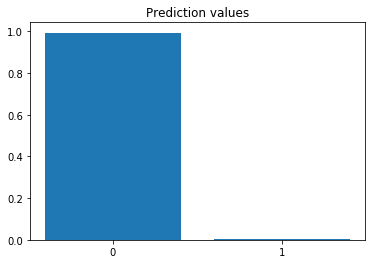

In [54]:
for i in range(1000):
    index = random.randrange(len(predictions))
    if most_likely[index] != y_test[index]:
        break

print(x_test[index])
print('Prediction: %d, label: %d' % (most_likely[index], y_test[index]))

plt.bar(range(2), predictions[index], tick_label=range(2))
plt.title('Prediction values')
plt.show()

In [55]:
text = []
labels = []
preds = []
for i in range(len(predictions)):
  if most_likely[i] != y_test[i]:
    text.append(x_test[i])
    labels.append(y_test[i])
    preds.append(most_likely[i])

errors = pd.DataFrame({'Comment':text, 'Sentiment':labels, 'Predictions':preds})
errors.head()

,Comment,Sentiment,Predictions
0,It definitely was not as good as my S11.,1,0
1,You get extra minutes so that you can carry ou...,1,0
2,This place deserves one star and 90% has to do...,0,1
3,The lead man is charisma-free.,0,1
4,A world better than 95% of the garbage in the ...,1,0
